In [64]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [97]:
import torch
import torch.nn as nn
import h5py
import numpy as np
from sklearn.preprocessing import OrdinalEncoder

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
device = torch.device('cuda')
# device = torch.device('cpu')

In [4]:
import os
os.chdir('/home/aisinai/work/repos/nis_patient_encoding/')

In [5]:
from data.data_loader import NISDatabase

from utils.experiments import *
from utils.feature_utils import calc_output_dims

from model.autoencoder.autoencoder import AutoEncoder
from model.autoencoder.loss import CustomLoss
from trainer.trainer import Trainer

In [6]:
import umap

In [7]:
embedding = umap.UMAP().fit_transform(np.random.rand(1000, 2))

KeyboardInterrupt: 

## New

In [61]:
from similarity.run_match import *

In [9]:
config_ts = json.load(open('similarity/savr_tavr.json', 'r'))
config_ts = init(config_ts)

In [10]:
import tsnecuda
import tables
from tqdm import tqdm

In [68]:
step = 10
tsne_fitted_test = np.loadtxt(config_ts['global']['PROJECT_DIR'] + config_ts['global']['DATA_FOLDER'] + f'tsne_{step}.npy')

In [69]:
tsne_fitted_test.shape

(1736983, 2)

In [70]:
full_data = tables.open_file(config_ts['global']['PROJECT_DIR'] + config_ts['global']['DATA_FOLDER'] + 'safety/NIS_Pruned.h5', 'r')
# ind_mapping = tables.open_file(config_ts['global']['PROJECT_DIR'] + config_ts['global']['DATA_FOLDER'] + 'safety/NIS_2012_2014_proto_emb_red.h5', 'r').root.TRAIN

outcomes = full_data.root.outcomes
outcome_headers = full_data.root.outcome_headers[:].astype('str')

In [71]:
# oc = np.empty((tsne_fitted_test.shape[0], full_data.root.outcomes.shape[1]))
oc = []

for row in tqdm(full_data.root.outcomes.iterrows(start=0, step=step), total=full_data.root.outcomes.shape[0] / step):
    oc.append(row)

oc = np.array(oc)

rd = []
for row in tqdm(full_data.root.dataset.iterrows(start=0, step=step), total=full_data.root.dataset.shape[0] / step):
    rd.append(row)
rd = np.array(rd)

1736983it [00:28, 61297.15it/s]                               
1736983it [01:22, 20955.74it/s]                               


In [72]:
oc[oc[:, 3] < 0, 3] = 0

In [73]:
oc[:, 4] = OrdinalEncoder().fit_transform(oc[:, 4].reshape(-1, 1)).reshape(-1)

In [74]:
oc[:, 4] = OrdinalEncoder().fit_transform(oc[:, 4].reshape(-1, 1)).reshape(-1)

In [75]:
oc[oc[:, 6] < 0, 6] = 0
oc[:, 6] = oc[:, 6].astype('float')

In [77]:
def plot_latent_space(d, h, title, hue_norm=None):
    
    plt.style.use('bmh')
    plt.style.use("seaborn-ticks")
    
    sns.set_context("paper")
    sns.set_palette("colorblind")
    
    fig, ax = plt.subplots(figsize=(8, 8))
    
    title_params = {
        'fontsize' : 18,
        'fontweight' : 'bold',
        'pad' : 9,
    }
    
    xaxis_params = {
        'fontsize' : 12,
        'labelpad' : 6
    }
    
    yaxis_params = {
        'fontsize' : 12,
        'labelpad' : 6
    }
        
    if hue_norm is not None:
        axis = sns.scatterplot(x=d[:, 0], y=d[:, 1], hue=h, hue_norm=hue_norm, alpha=0.1, linewidth=0.1, s=3, ax=ax)
    else:
        axis = sns.scatterplot(x=d[:, 0], y=d[:, 1], hue=h, alpha=0.1, linewidth=0.1, s=3, ax=ax)
    
    axis.set_title(title, **title_params)
    axis.xaxis.set_visible(False)
    axis.yaxis.set_visible(False)
    
    fig.tight_layout(pad=3)
    fig.savefig(f'/home/aisinai/work/repos/nis_patient_encoding/figures/supp_figure2_tsne_{title}_{step}.png', bbox_inches='tight')
    
#     with sns.plotting_context('talk'):
#         sns.set(style="white")
#         fig, ax = plt.subplots(figsize=(10, 10))
#         pl = sns.scatterplot(x=d[:, 0], y=d[:, 1], hue=h, alpha=1, linewidth=0.1, ax=ax).set(title='UMAP - Age')    
        

In [93]:
del Axes3D

In [94]:
tsne_fitted_test.shape, rd.shape

((1736983, 2), (1736983, 229))

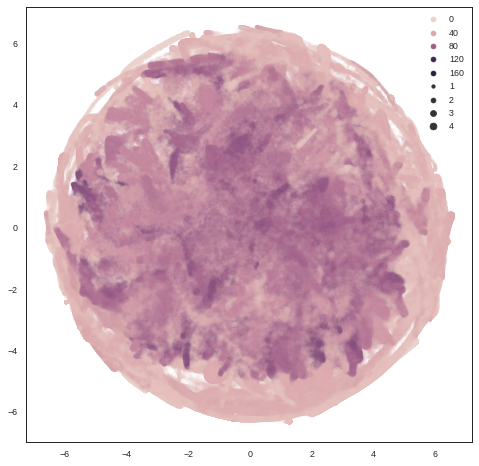

In [105]:
plt.style.use('bmh')
plt.style.use("seaborn-ticks")

sns.set_context("paper")
sns.set_palette("colorblind")

fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(tsne_fitted_test[::1, 0], tsne_fitted_test[::1, 1], hue=rd[::1, 0], size=rd[::1, -1], alpha=0.1, linewidth=0.1, ax=ax)

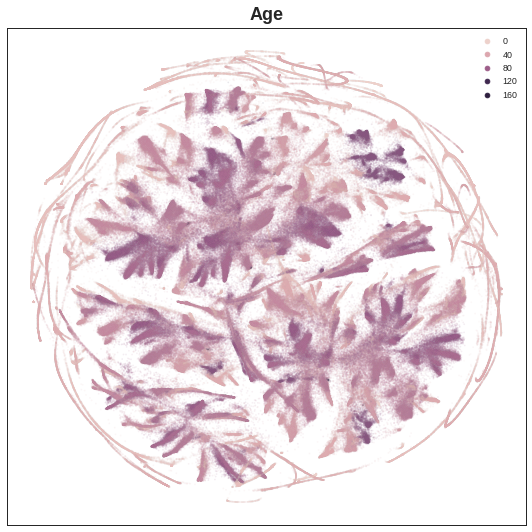

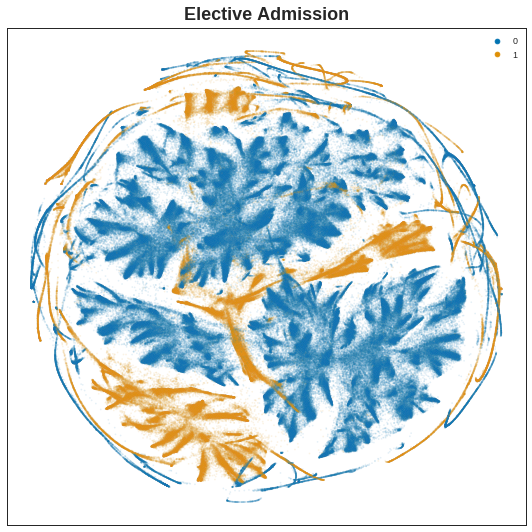

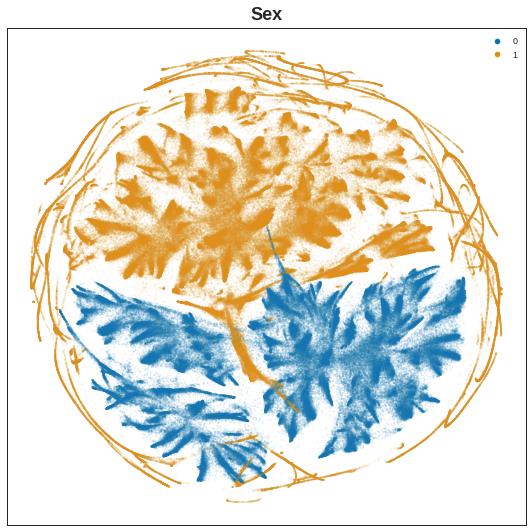

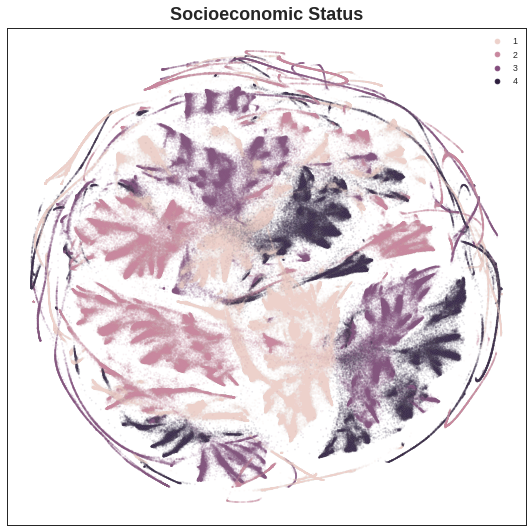

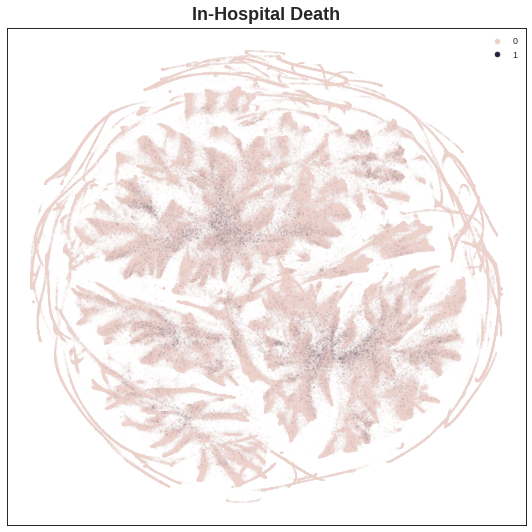

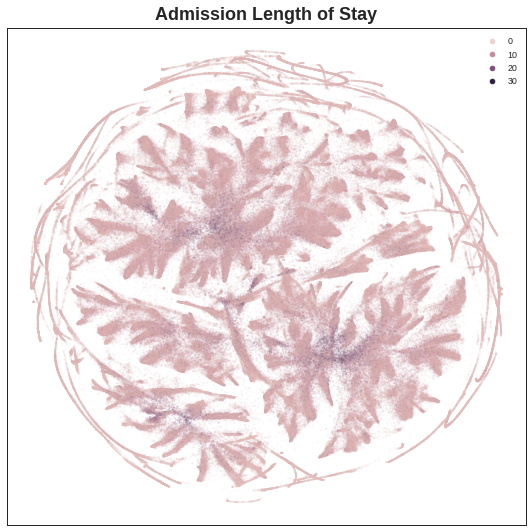

In [59]:
plot_latent_space(tsne_fitted_test, rd[:, 0], 'Age')
plot_latent_space(tsne_fitted_test, rd[:, full_data.root.headers[:].tolist().index(b'ELECTIVE')], 'Elective Admission')
plot_latent_space(tsne_fitted_test, rd[:, full_data.root.headers[:].tolist().index(b'FEMALE')], 'Sex')
plot_latent_space(tsne_fitted_test, rd[:, -1], 'Socioeconomic Status')
plot_latent_space(tsne_fitted_test, oc[:, 3], 'In-Hospital Death', hue_norm=(0, 1))
plot_latent_space(tsne_fitted_test, oc[:, 6], 'Admission Length of Stay', hue_norm=(0, 30))

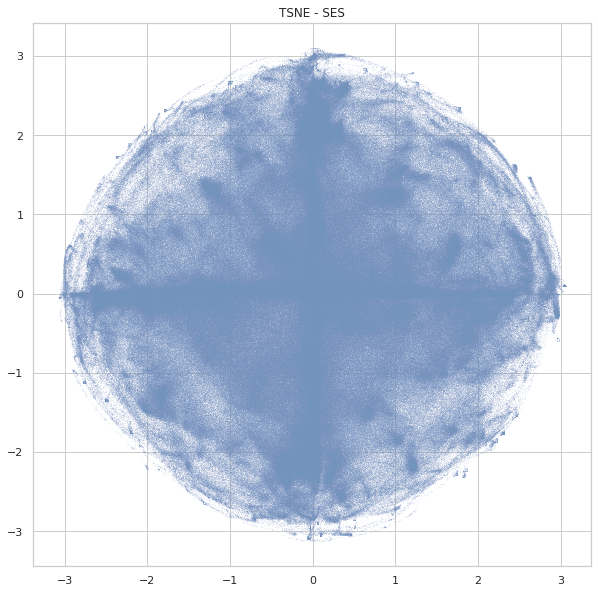

In [23]:
with sns.plotting_context('poster'):
    sns.set(style="whitegrid")
    fig, ax = plt.subplots(figsize=(10, 10))
    k = sns.scatterplot(x=tsne_fitted_test[:, 0], y=tsne_fitted_test[:, 1], alpha=0.1, linewidth=0.1, ax=ax, s=1)
    k.set(title='TSNE - SES')
    plt.show()

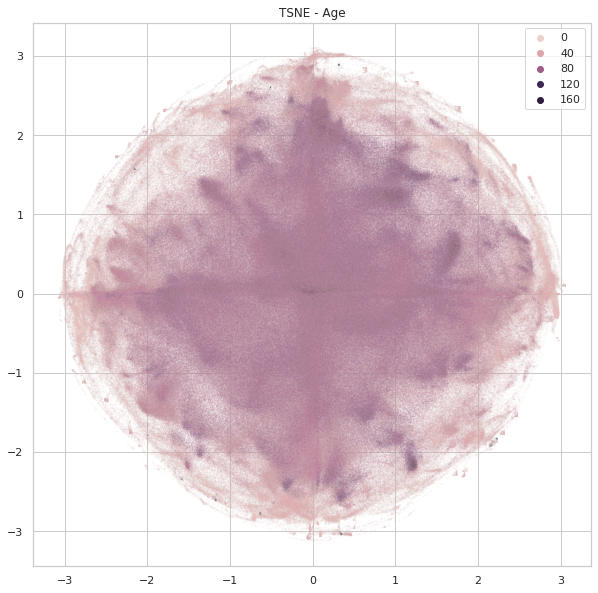

In [34]:
with sns.plotting_context('poster'):
    sns.set(style="whitegrid")
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.scatterplot(x=tsne_fitted_test[:, 0], y=tsne_fitted_test[:, 1], hue=rd[:, 0], alpha=0.1, linewidth=0.1, ax=ax, s=1).set(title='TSNE - Age')

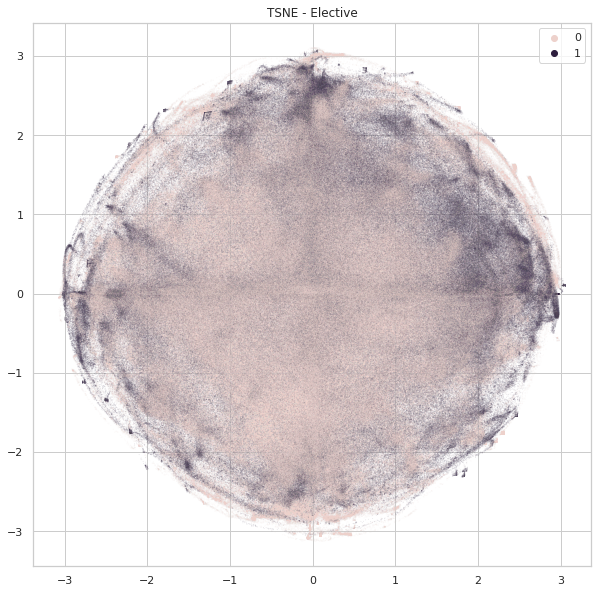

In [33]:
with sns.plotting_context('poster'):
    sns.set(style="whitegrid")
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.scatterplot(x=tsne_fitted_test[:, 0], y=tsne_fitted_test[:, 1], hue=rd[:, full_data.root.headers[:].tolist().index(b'ELECTIVE')], hue_norm=(0, 1), s=1, alpha=0.1, linewidth=0.1, ax=ax).set(title='TSNE - Elective')

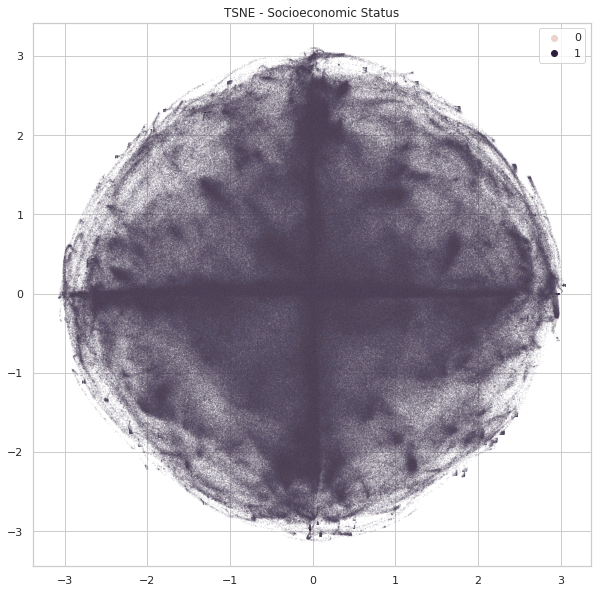

In [30]:
with sns.plotting_context('poster'):
    sns.set(style="whitegrid")
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.scatterplot(x=tsne_fitted_test[:, 0], y=tsne_fitted_test[:, 1], hue=rd[:, -1], s=1, hue_norm=(0, 1), alpha=0.1, linewidth=0.1, ax=ax).set(title='TSNE - Socioeconomic Status')

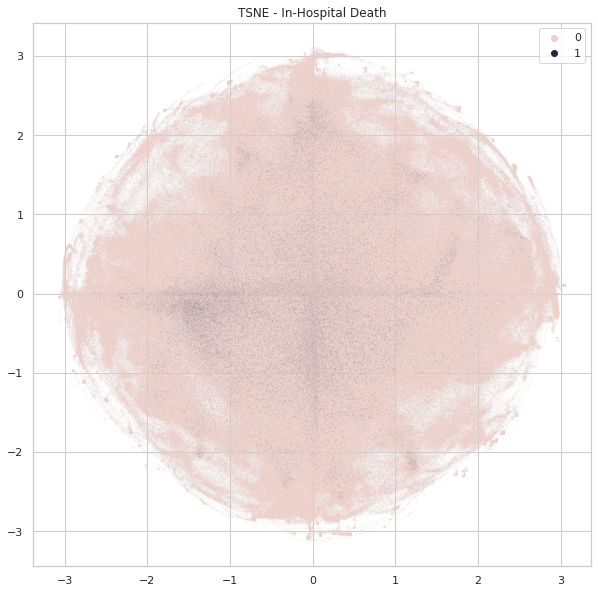

In [35]:
with sns.plotting_context('poster'):
    sns.set(style="whitegrid")
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.scatterplot(x=tsne_fitted_test[:, 0], y=tsne_fitted_test[:, 1],  hue=oc[:, 3], hue_norm=(0, 1), s=1, alpha=0.1, linewidth=0.1, ax=ax).set(title='TSNE - In-Hospital Death')

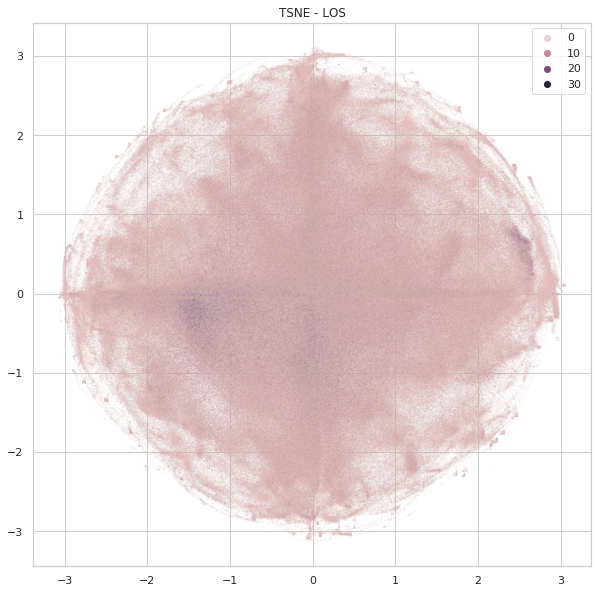

In [36]:
with sns.plotting_context('poster'):
    sns.set(style="whitegrid")
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.scatterplot(x=tsne_fitted_test[:, 0], y=tsne_fitted_test[:, 1], hue=oc[:, 6], hue_norm=(0, 30), s=1, alpha=0.1, linewidth=0.1, ax=ax).set(title='TSNE - LOS')

In [46]:
full_data.root.outcome_headers[:]

array([b'APRDRG', b'APRDRG_Risk_Mortality', b'APRDRG_Severity', b'DIED',
       b'DISPUNIFORM', b'DRG', b'LOS', b'TOTCHG'], dtype='|S21')

In [70]:
np.unique(oc[:, 6])

array([-128, -127, -126, -125, -124, -123, -122, -121, -120, -119, -118,
       -117, -116, -114, -113, -112, -110, -109, -108, -107, -106, -105,
       -104, -103, -102, -101, -100,  -99,  -98,  -97,  -96,  -95,  -94,
        -93,  -91,  -90,  -89,  -88,  -87,  -86,  -85,  -83,  -82,  -81,
        -80,  -79,  -78,  -77,  -76,  -75,  -74,  -73,  -71,  -70,  -69,
        -68,  -67,  -66,  -65,  -64,  -63,  -62,  -61,  -59,  -58,  -57,
        -56,  -55,  -52,  -51,  -50,  -49,  -48,  -47,  -46,  -45,  -44,
        -43,  -41,  -40,  -37,  -35,  -34,  -33,  -32,  -31,  -30,  -29,
        -28,  -27,  -26,  -25,  -24,  -22,  -19,  -17,  -15,  -13,  -12,
         -8,   -7,   -6,   -5,   -1,    0,    1,    2,    3,    4,    5,
          6,    7,    8,    9,   10,   11,   12,   13,   14,   15,   16,
         17,   18,   19,   20,   21,   22,   23,   24,   25,   26,   27,
         28,   29,   30,   31,   32,   33,   34,   35,   36,   37,   38,
         39,   40,   41,   42,   43,   44,   45,   

In [62]:
from sklearn.preprocessing import OrdinalEncoder

In [ ]:
oc[oc[:, 3] < 0, 3] = 0

In [66]:
oc[:, 4] = OrdinalEncoder().fit_transform(oc[:, 4].reshape(-1, 1)).reshape(-1)

In [72]:
oc[oc[:, 6] < 0, 6] = 0
oc[:, 6] = oc[:, 6].astype('float')